In [32]:
from jax import numpy as jnp
import jax
import optax
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, f1_score
from quantum_model import quantum_neural_network
import pennylane as qml
from sklearn.utils import gen_batches
import numpy as np
import tensorflow as tf
from keras.datasets import mnist
import matplotlib.pyplot as plt

# Introduction:
## Good morning, 
This is a simple tutorial on quantum neural network (QNN) with **data-reuploding techinque**. The neural net is trained on the MNIST dataset initially (the classification is binary, we select 0,1 classes), and then, we try to evaluate it also on a specific case of MedMNIST dataset, trying to be more realistic. Lastly, we implement a QCNN and we will see what happens with it.
I recommend that I realized this work by combining some parts taken from other repos and adapted to my problem. I have some little doubts on few parts, but I will try to explain everything as I can.

**Requirements:**

**JAX** (for optimization, a specific version of numpy which suits with JAX functions and vectorization, but PyTorch is good anyway);

**optax** (for optimizers to combine with JAX);

**tensorflow and Keras** (to create the dataset and to use the *resize* method to downsample an image);

**sklearn** (for accuracy_score in the test, gen_batches to generate batches of images and labels and to split train, val, test set);

**Pennylane** (for quantum computing).


## Dataset

We define the **downsample** function to resize or downsample an image in terms of pixels. Obviosouly, I will not use (28x28) MNIST images on a quantum nn since the number of parameters inside rotational gates would increase too much. Rather, I will work with less pixels/features.
**RandomMnist** is a class that create only train and validation sets from the training MNIST images inside Keras. Note that the images only come from the train tuple of Keras and we use sklearn to extract a fraction of them to create the smaller validation set. By doing so, we are sure that the images we would use in the TEST set wouldn't be contained in the previous train and val sets. 
Inside the class we declare the number of training images to work with, the specific classes, a shuffle to shuffle the dataset before extracting the vectors of Xs and ys, a resize integer to resize the image according to the vlaue we insert and a seed for reproducibility, i. e. using the same seed the train and validation set will be the same even though we apply the same method many times.


In [10]:
def down_sample(x_array: np.ndarray, size: int) -> np.ndarray:
    """
    Function that reduces size of the images array.
    Args:
        x_array (array): image array.
        size (int): new size to resize.
    Returns:
        new_array (array): resized image.
    """
    new_size = (size, size)
    x_array = np.reshape(x_array, (x_array.shape[0], x_array.shape[1], 1))
    new_array = tf.image.resize(x_array, new_size)
    return new_array.numpy()

class RandomMnist:
    """
    Class that creates a binary dataset out of Mnist after specifying the classes of images to deal with,
    based on Keras's API.
    The dataset created here is composed by train and validation set.
    Args:
        classes_of_items (list): classes of images;
        num_train_samples (int): number of training images;
        shuffle (bool): if True the images are shuffled before creating the dataset;
        resize (int): new image dimension (it must be lower than 28);
        my_seed (int): seed for reproducibility.
    Returns:
        X_train (array): set of training images of shape (num_images, new_shape*new_shape);
        y_train (array): set of training labels of shape (num_images,);
        X_val (array): set of validation images of shape (num_images, new_shape*new_shape);
        y_val (array): set of validation labels of shape (num_images,).
    Note that the number of validation data is 0.2*num_train_samples.
    """

    def __init__(self, classes_of_items: list, num_train_samples: int, shuffle: bool,
                 resize: int, my_seed: int) -> None:
        self.classes_of_items = classes_of_items
        self.num_train_samples = num_train_samples
        self.shuffle = shuffle
        self.resize = resize
        self.my_seed = my_seed

    def data(self) -> tuple:
        np.random.seed(self.my_seed)
        (train_X, train_y), (_, _) = mnist.load_data()
        X_train_filtered = train_X[np.isin(train_y, [self.classes_of_items[0], self.classes_of_items[1]])]
        y_train_filtered = train_y[np.isin(train_y, [self.classes_of_items[0], self.classes_of_items[1]])]

        X_train_filtered = X_train_filtered.astype('float16') / 255
        X_train_new = []
        if self.resize is not None and self.resize <= 28:
            for train in X_train_filtered:
                X_train_new.append(down_sample(train, self.resize))
        else:
            raise Exception("The new size must be smaller than the actual Mnist size that is 28!")
        # shuffle
        X_train_new = np.array(X_train_new)
        if self.shuffle:
            shuffled_indices = np.arange(len(X_train_new))
            np.random.shuffle(shuffled_indices)
            X_train_new = X_train_new[shuffled_indices]
            y_train_filtered = y_train_filtered[shuffled_indices]

        if self.num_train_samples is not None:
            num_samples_per_class = self.num_train_samples // len(self.classes_of_items)
            selected_indices = []
            for class_idx in self.classes_of_items:
                class_indices = np.where(y_train_filtered == class_idx)[0][:num_samples_per_class]
                selected_indices.extend(class_indices)
            X_train_ = X_train_new[selected_indices]
            y_train_filtered = y_train_filtered[selected_indices]
        else:
            raise RuntimeError("Insert number of images to form the train set.")

        X_train_ = X_train_.reshape(X_train_.shape[0], X_train_.shape[1] * X_train_.shape[2])
        X_train_final, X_val, y_train_final, y_val = train_test_split(
            X_train_, y_train_filtered, test_size=0.2, random_state=42)

        return (
            jnp.asarray(X_train_final),
            jnp.asarray(y_train_final),
            jnp.asarray(X_val),
            jnp.asarray(y_val),
        )

Note that the X_train, y_train, X_val and y_val are JAX arrays!

## Quantum model

Let's create the quantum model with my method, but I will be happy to learn a new method!
The class contains a feature map circuit which is composed by a sequence of U3 gates to embed all the 64 features (we downscale the images to be (8x8) MNIST images) and a parameterized ansatz to learn 69 parameters each layer. Now we will display everything and we will understand how they work.

In [12]:
class quantum_neural_network:
    def __init__(self, n_wires: int) -> None:
        self.n_wires = n_wires
    def QuantumMap(self, X_data: jnp.ndarray) -> None:
        """
            Quantum feature map composed by U3 gates.
            :arg:
                X_data: jax.numpy array input image.
            :return:
                quantum feature map to map classical features into quantum state.
        """
        idx = 0
        qml.Barrier(only_visual=True)
        for i in range(self.n_wires):
            qml.Rot(phi=X_data[idx + 0], theta=X_data[idx + 1], omega=X_data[idx + 2], wires=i)
            idx += 3
            qml.Rot(phi=X_data[idx + 0], theta=X_data[idx + 1], omega=X_data[idx + 2], wires=i)
            idx += 3
        for j in range(5):
            qml.Rot(phi=X_data[idx + 0], theta=X_data[idx + 1], omega=X_data[idx + 2], wires=j)
            idx += 3
        qml.RZ(phi=X_data[63], wires=5)  # Only 64 features
        qml.Barrier(only_visual=True)
    def QuantumRing_layer(self, params: jnp.ndarray) -> None:
        """
            Quantum ansatz composed by U3 gates and ring-like CNOT entangling scheme.
            :arg: self, params (jaa.numpy array of parameters).
            :return: to be connected to the feature map.
        """
        idx = 0
        for i in range(self.n_wires):
            qml.Rot(phi=params[0 + idx], theta=params[1 + idx], omega=params[2 + idx], wires=i)
            idx += 3
        qml.Barrier(only_visual=True)
        for j in range(self.n_wires - 1):
            qml.CRot(phi=params[idx + 0], theta=params[idx + 1], omega=params[idx + 2], wires=[j, j + 1])
            idx += 3
        qml.Barrier(only_visual=True)
        for k in range(self.n_wires):
            qml.Rot(phi=params[0 + idx], theta=params[1 + idx], omega=params[2 + idx], wires=k)
            idx += 3

In [18]:
layers1 = 2  # Declare how many layers you want
n_qubits = 8
dev = qml.device('default.qubit', wires=n_qubits)

@qml.qnode(dev, interface='jax')
def quantum_nn(X, thetas):
    model = quantum_neural_network(n_wires=n_qubits)
    params_per_sublayer = 69  ### each layer will learn 69 parameters
    for layer in range(layers1):
        model.QuantumMap(X)
        j = layer * params_per_sublayer
        model.QuantumRing_layer(thetas[j:j+(params_per_sublayer)],)
        j += (params_per_sublayer)*(layer)
    qml.Barrier(wires=range(n_qubits),only_visual=True)
    return qml.probs(wires=0)

We work with 8 **qubits**.
Since we use always U3 gates we have 3 **param_per_gate**. 
We use also ControlledU3 gates for entanglement so we have one gate less with respect to the number of qubits -> **entangling_gate = qubits - 1**.

In [14]:
param_per_gate = 3 
entangling_gate = 7
new_shape = 8
# Call the train and val sets
dataset = RandomMnist(classes_of_items=[0, 1], num_train_samples=500, shuffle=True, resize=new_shape, my_seed=999)
X_train, y_train, X_val, y_val = dataset.data()

(<Figure size 3600x900 with 1 Axes>, <Axes: >)

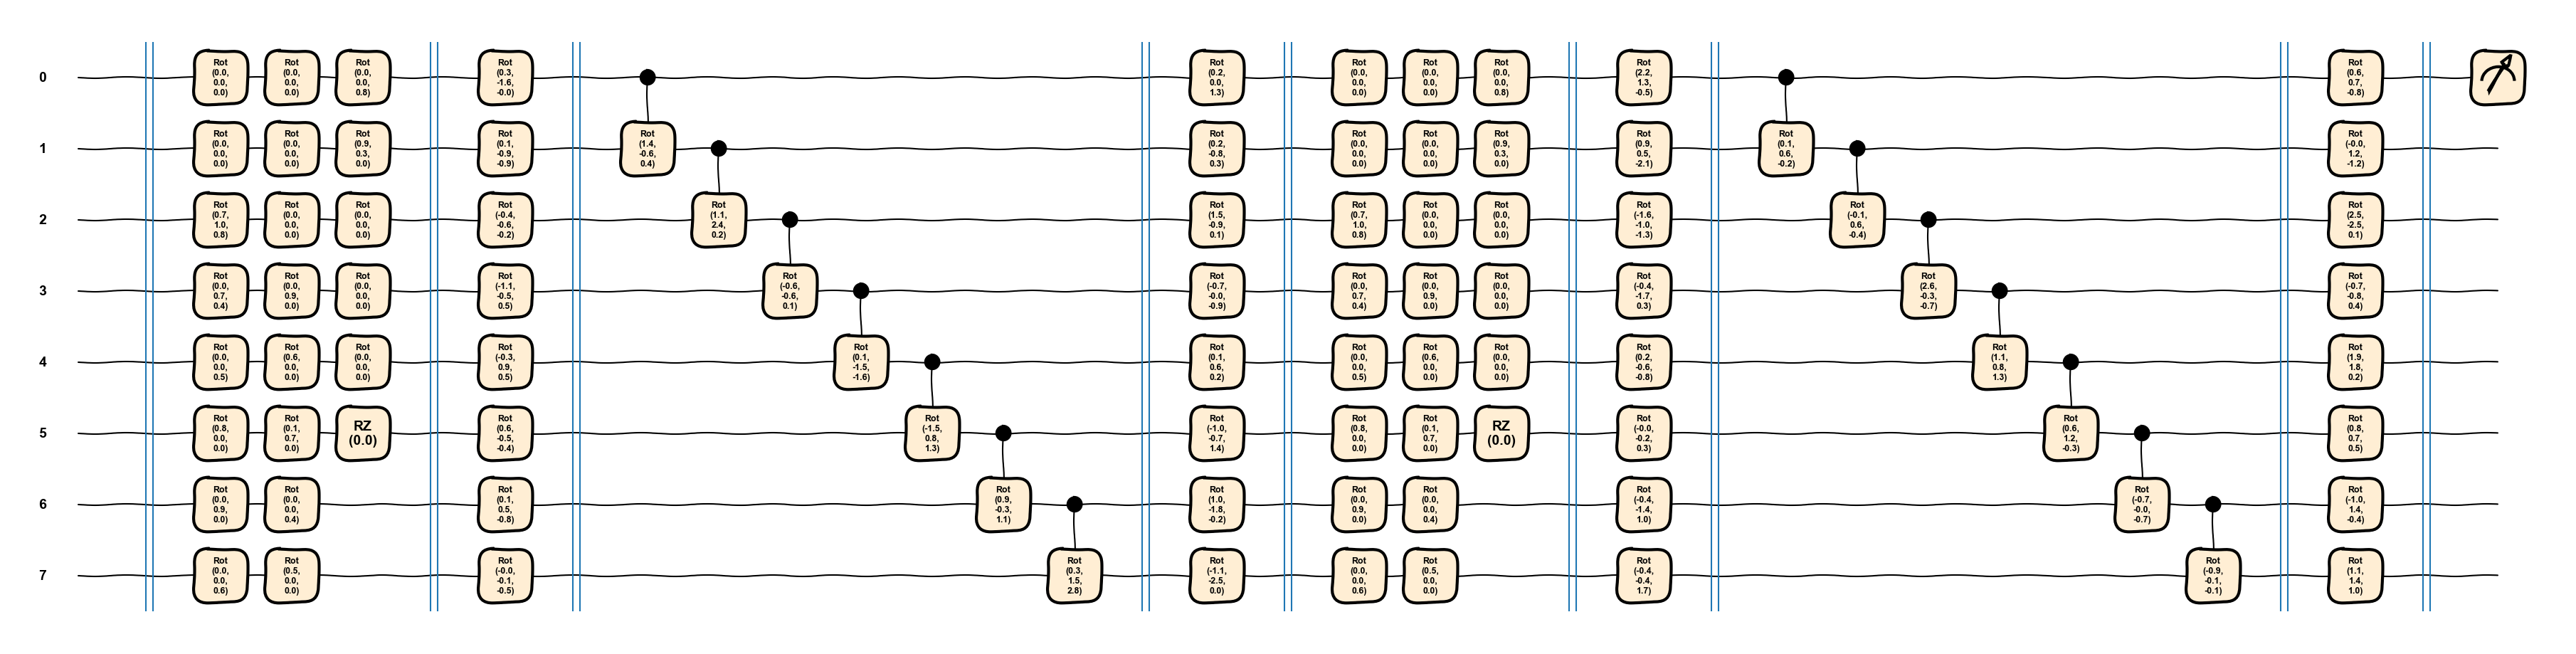

In [19]:
seed = 78
key = jax.random.PRNGKey(seed)
initial_params = jax.random.normal(key, shape=((param_per_gate * n_qubits + param_per_gate * entangling_gate +
                                                param_per_gate * n_qubits) * layers1,))
qml.draw_mpl(qnode=quantum_nn, style="sketch", decimals=1)(X_train[0], initial_params)

As we can see, the parameters inside the ansatz are different in each layer, while features remain the same and are re-uploaded at each layer, whose number could be modified. The probabilities of getting a class 0 or 1 are measured after the circuit. 

## Useful functions before starting

These functions are:
 
**binary_crossentropy** which computes the output (i.e., a probability of getting the image 0 or 1) and loops through each output (which is an array of the form (number_of_elements, 2) since for each element I have 2 probabilities) and each true label (which is a vector of
(number_of_elements, 1)) and applies binary cross-entropy formula;

**optimizer_update** which updates the parameters after each iteration;

**accuracy** which calculates the output, extracts the index of the largest probability and compares it to the corresponding true label.

The **@jax.jit** should need for optimization.


In [20]:
@jax.jit
def binary_crossentropy(x, y, theta):
    labels = jnp.array(y)
    pred = jnp.array(qnn(x, theta))
    loss = 0
    for l, p in zip(labels, pred):
        loss += l * (jnp.log(p[l])) + (1 - l) * jnp.log(1 - p[1 - l])
    return -jnp.sum(loss)/len(labels)

@jax.jit
def optimizer_update(opt_state, params, x, y):
    loss_value, grads = jax.value_and_grad(lambda theta: binary_crossentropy(x, y, theta))(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

@jax.jit
def accuracy(X, y, params):
    labels = jnp.array(y)
    predictions = jnp.array(qnn(X, params))
    correct_predictions = jnp.sum(jnp.argmax(predictions, axis=1) == labels)
    return correct_predictions / len(labels)

### Set some hyper-parameters

In [21]:
lr = 0.01
n_epochs = 200
batch_size = 32

qnn_batched = jax.vmap(quantum_nn, (0, None,)) # use vmap to apply quantum_nn function to a vector, it's typical in JAX.
qnn = jax.jit(qnn_batched)
optimizer = optax.adam(learning_rate=lr)

In [22]:
key = jax.random.split(key)[0]
params = jnp.copy(initial_params)
opt_state = optimizer.init(initial_params)

train_cost_epochs, train_acc_epochs, val_cost_epochs, val_acc_epochs = [], [], [], []
for epoch in range(1,n_epochs+1):
    idxs_dataset = jax.random.choice(key, jnp.array(list(range(X_train.shape[0]))), shape=(X_train.shape[0],), replace=False)
    key = jax.random.split(key)[0]
    for i in gen_batches(X_train.shape[0], batch_size): ## we use gen_batches to optimize and calculate the gradient during each batch
        idxs = idxs_dataset[i]
        params, opt_state, cost = optimizer_update(opt_state, params, X_train[idxs, :], y_train[idxs])
        cost = binary_crossentropy(X_train, y_train, params,)
        val_cost = binary_crossentropy(X_val, y_val, params,)
        train_acc = accuracy(X_train, y_train, params,) 
        val_acc = accuracy(X_val, y_val, params,)
    train_cost_epochs.append(cost)
    val_cost_epochs.append(val_cost)
    # Accuracy during training and validation
    train_acc_epochs.append(train_acc)
    val_acc_epochs.append(val_acc)
    print(f"Epoch: {epoch}, ---Train loss: ", cost, "---Val loss: ", val_cost, "---Train acc: ", train_acc,
          "---Val acc.: ", val_acc)
    optimal_params = params  # Optimal parameters after training saved here, ready to be used for predictions.

Epoch: 1, ---Train loss:  0.6017588 ---Val loss:  0.63504195 ---Train acc:  0.715 ---Val acc.:  0.59999996
Epoch: 2, ---Train loss:  0.5841071 ---Val loss:  0.6424547 ---Train acc:  0.78749996 ---Val acc.:  0.72999996
Epoch: 3, ---Train loss:  0.55228055 ---Val loss:  0.5927823 ---Train acc:  0.79249996 ---Val acc.:  0.69
Epoch: 4, ---Train loss:  0.5312481 ---Val loss:  0.5722231 ---Train acc:  0.805 ---Val acc.:  0.74
Epoch: 5, ---Train loss:  0.51533693 ---Val loss:  0.5578808 ---Train acc:  0.8275 ---Val acc.:  0.76
Epoch: 6, ---Train loss:  0.50208616 ---Val loss:  0.5469006 ---Train acc:  0.8325 ---Val acc.:  0.74
Epoch: 7, ---Train loss:  0.49140972 ---Val loss:  0.5306903 ---Train acc:  0.825 ---Val acc.:  0.75
Epoch: 8, ---Train loss:  0.4814161 ---Val loss:  0.52094 ---Train acc:  0.835 ---Val acc.:  0.74
Epoch: 9, ---Train loss:  0.47307375 ---Val loss:  0.5180834 ---Train acc:  0.8325 ---Val acc.:  0.74
Epoch: 10, ---Train loss:  0.46488482 ---Val loss:  0.506855 ---Train a

## Plots

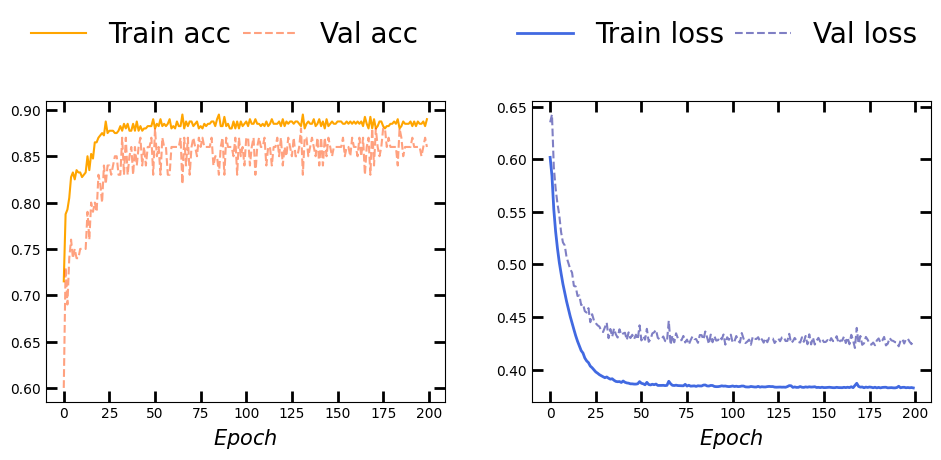

In [31]:
plt.style.use("default")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(train_acc_epochs, label="Train acc", color="orange")
axs[0].plot(val_acc_epochs, label="Val acc", color="orangered", alpha=0.5, ls='--')
axs[0].set_xlabel("Epoch")
axs[1].plot(train_cost_epochs, label="Train loss", color="royalblue", mfc='white', markersize=6, lw=2)
axs[1].plot(val_cost_epochs, label="Val loss", color="darkblue", alpha=0.5, mfc='white', markersize=6, ls='--')
axs[1].set_xlabel("Epoch")
axs[1].legend(fontsize=20, framealpha=0, ncol=2, columnspacing=0.4, loc='upper left', bbox_to_anchor=(-0.1, 1.35))
axs[0].legend(fontsize=20, framealpha=0, ncol=2, columnspacing=0.4, loc='upper left', bbox_to_anchor=(-0.1, 1.35))
axs[0].set_xlabel(r'$Epoch$', fontsize=15)
axs[1].set_xlabel(r'$Epoch$', fontsize=15)
axs[0].tick_params(direction='in', length=8, width=2, top='on', right='on', labelsize=10)
axs[1].tick_params(direction='in', length=8, width=2, top='on', right='on', labelsize=10)
plt.tight_layout()

# Test the model

We now create the TEST set by using the SECOND tuple of Keras: in this way we are 100% sure that the model will see new unseen images!

In [25]:
classes_of_items = [0,1]
num_samples = 300
num_samples_per_class = num_samples / 2

(_, _), (X_test, y_test) = mnist.load_data()

mask = np.isin(y_test, classes_of_items)
X_test_filtered = X_test[mask]
y_test_filtered = y_test[mask]

X_test_new = [down_sample(x_test, 8) for x_test in X_test_filtered]
X_test_final = np.array(X_test_new).reshape(len(X_test_new), -1) / 255.0
y_test_final = np.array(y_test_filtered)

selected_indices = []
for class_idx in classes_of_items:
    class_indices = np.where(y_test_filtered == class_idx)[0][:int(num_samples_per_class)]
    selected_indices.extend(class_indices)

# Shuffle selected indices
np.random.shuffle(selected_indices)


X_test_final = X_test_final[selected_indices]
y_test_final = y_test_final[selected_indices]
X_test_final = jnp.asarray(X_test_final)
y_test_final = jnp.asarray(y_test_final)

In [27]:
print("Number of 0s in the TEST set:", np.count_nonzero(y_test_final == 0))
print(" ")
print("Number of 1s in the TEST set:", np.count_nonzero(y_test_final == 1))

Number of 0s in the TEST set: 150
 
Number of 1s in the TEST set: 150


In [28]:
def prediction(ytrue, qnn, opt_weights):
    ypred = jnp.array(qnn(X_test_final.T, opt_weights))  ## I used .T because I had a bug without it.
    estimated_lab = jnp.array([jnp.argmax(label) for label in ypred])
    return [np.round(accuracy_score(jnp.array(ytrue), estimated_lab),2), estimated_lab]

prediction(y_test_final, quantum_nn, optimal_params)[0]

0.87

F1-score:  0.8773006134969326


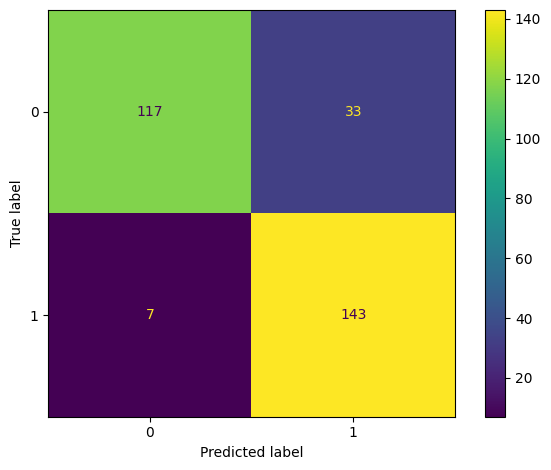

In [33]:
ConfusionMatrixDisplay(confusion_matrix(y_true=y_test_final, y_pred=prediction(y_test_final, quantum_nn, optimal_params)[1])).plot()

plt.tight_layout()

print("F1-score: ", f1_score(y_test_final, prediction(y_test_final, quantum_nn, optimal_params)[1]))

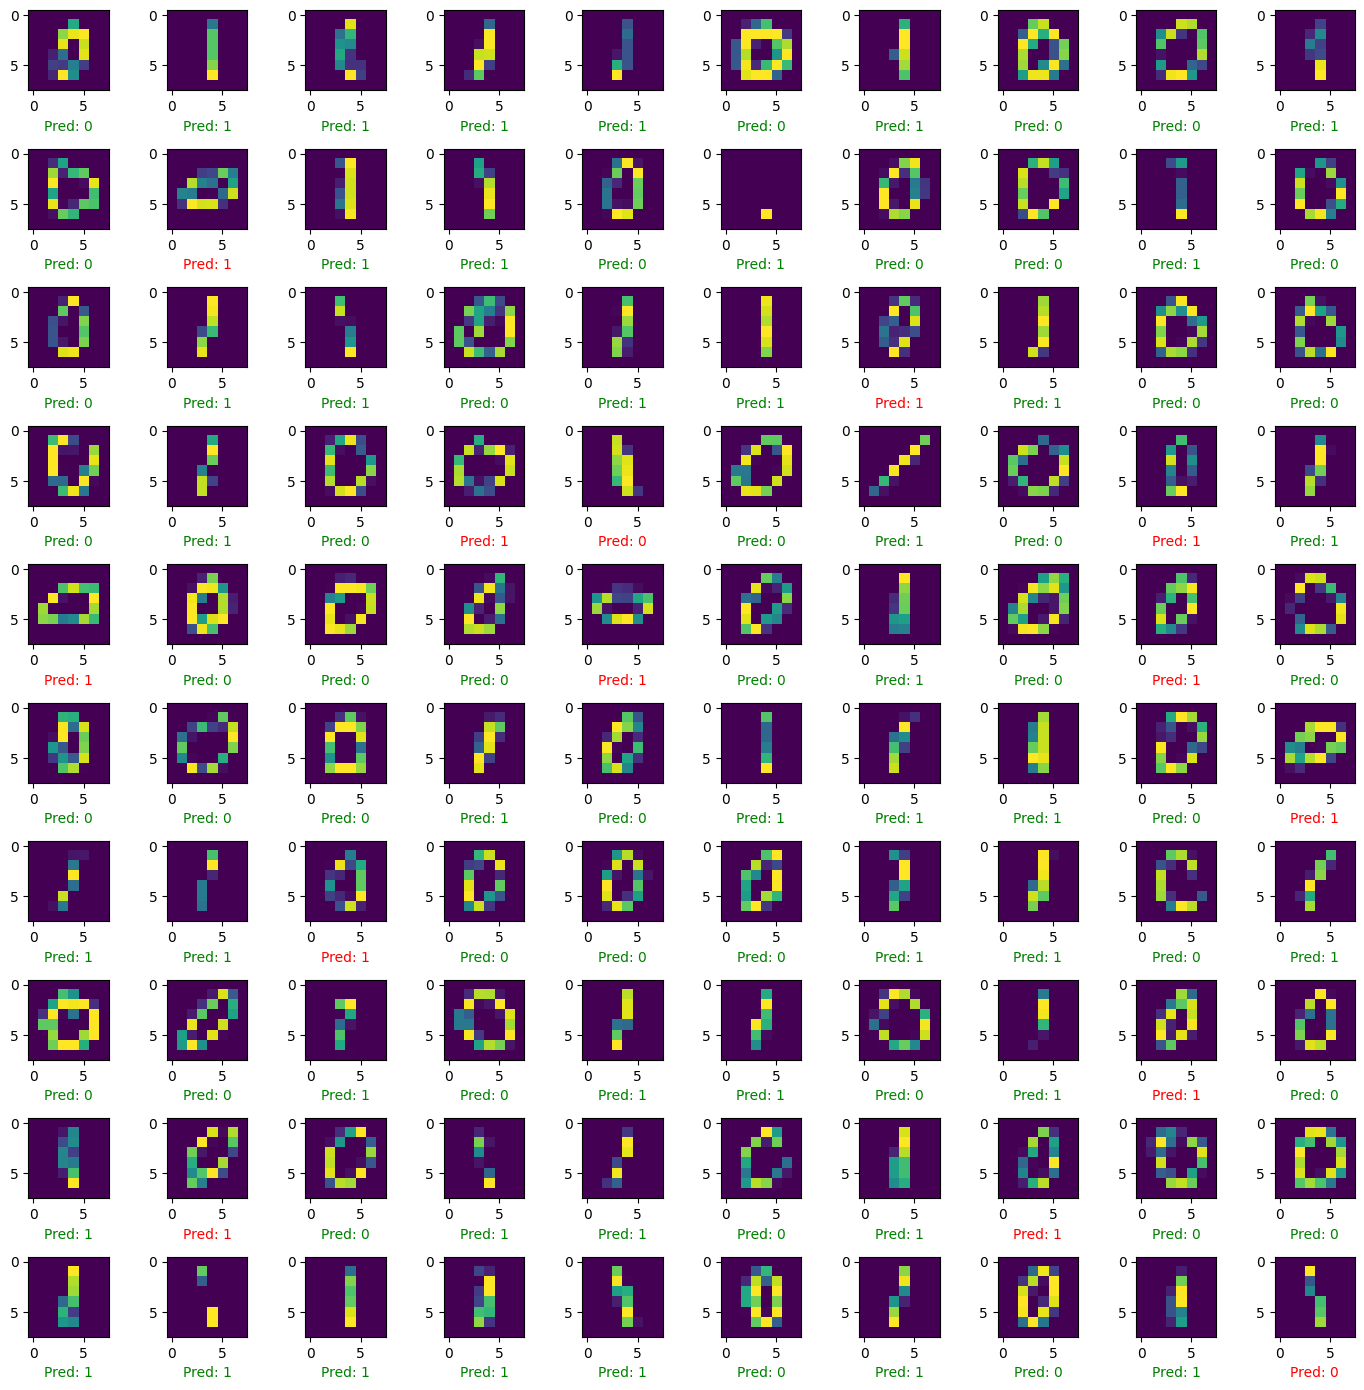

In [36]:
def plot_mnist_images(images, estimated_labels, num_images=100, num_cols=10):
    """
    Plot a grid of MNIST images.
    
    Args:
    - images (numpy.ndarray): Array of MNIST images
    - estimated_labels (numpy.ndarray): Array of estimated labels for the images
    - num_images (int): Number of images to plot (default is 100)
    - num_cols (int): Number of columns in the grid (default is 10)
    """
    num_rows = num_images // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 14))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape((8, 8)), cmap='viridis')  # Corrected image shape
        label_color = 'green' if estimated_labels[i] == y_test_final[i] else 'red'
        ax.set_xlabel("Pred: " + str(estimated_labels[i]), color=label_color)  # Setting label color based on match
    plt.tight_layout()
    plt.show()

plot_mnist_images(X_test_final[:100], prediction(y_test_final, quantum_nn, optimal_params)[1][:100])

## Thanks for reading and watching :)